<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>CET Template Notebook</b> <br>
Contact author(s): <i>Author Name</i> <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

**Description:** Example of a tutorial notebook exercise to explore deblender products. Would like to access the footprint, and plot deblended source centroids on top of the segmentation map (footprint) as a demonstration of how the deblender works.

In [1]:
# general python packages
import numpy as np
import os
import matplotlib.pyplot as plt
import gc
import time
plt.style.use('tableau-colorblind10')

# LSST package for TAP queries
from lsst.rsp import get_tap_service, retrieve_query

# LSST package for Butler queries
import lsst.daf.butler as Butler

# Familiar stack packages
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D
from lsst.afw.image import Exposure, Image, PARENT

# These may be less familiar objects dealing with multi-band data products
from lsst.afw.image import MultibandExposure, MultibandImage
from lsst.afw.detection import MultibandFootprint, Footprint

# LSST package for image display
import lsst.afw.display as afwDisplay
#import lsst.geom
import lsst.geom as geom

# Astropy imports
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.visualization import make_lupton_rgb
from photutils import * #SkyCircularAperture
from astropy.nddata import Cutout2D

# Pipeline tasks
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
afwDisplay.setDefaultBackend('matplotlib')

**Description:** Set up a function for plotting cutouts

In [2]:
# A function and settings  to plot a cutout from tutorial notebook 03a

def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

In [3]:
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"


#### Make a plot showing a blended source

<Figure size 3000x3000 with 0 Axes>

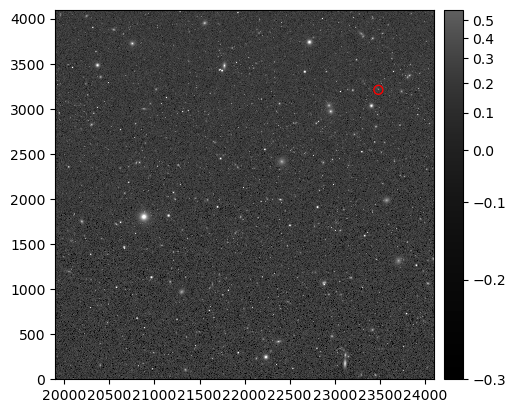

In [4]:
# prepare to do the cutout from tutorial notebook 03
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler.Butler(config, collections=collection)

datasetType = "deepCoadd"

# Choose a parent and deblended children. Here are a couple good ones:
#1329731770446283558	4574.5498478	5486.0082516	72.3165407	-42.8674071	True	0	False	True	True	True	False	1329731770446253832	4867	0.9493601	3085	8
#1248675773246610542	23484.4969535	3210.1552014	50.1089143	-44.4812763	False	13	False	False	False	False	False	0	3435	0.0	2897	5

tract = 2897
patch = 5

sel_objid = 1248675773246610542 
ra = 50.1089143
dec = -44.4812763
x = 23484.4969535
y = 3210.1552014


dataId = {'tract': tract, 'band': 'i', 'patch': patch }  
blend_coadd = butler.get(datasetType, **dataId)

# Take a look at the image of the patch
plt.figure(figsize=(30,30))
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(blend_coadd.getMaskedImage()) # what does getMaskedImage do?

# Plot the "Parent" source:
afw_display.dot('o', x, y, size=50, ctype=afwDisplay.RED)


### Identify the children that are deblended from the above parent source:

In [5]:
%%time

# first search on RA/Dec and then use a where statement to pull out targets based on ID    
query_children = "SELECT ObjectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId, footprintArea, z_blendedness, " + \
        "tract, patch " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(ra) + ", " + str(dec) + ", 0.01)) = 1 "   
    
results_children = service.search(query_children, maxrec=10000)
tab_children = results_children.to_table()

whc = np.where(tab_children['parentObjectId'] == sel_objid)[0]



CPU times: user 24.6 ms, sys: 381 µs, total: 24.9 ms
Wall time: 192 ms


### Create an image cutout centered on the parent + children to see it better:


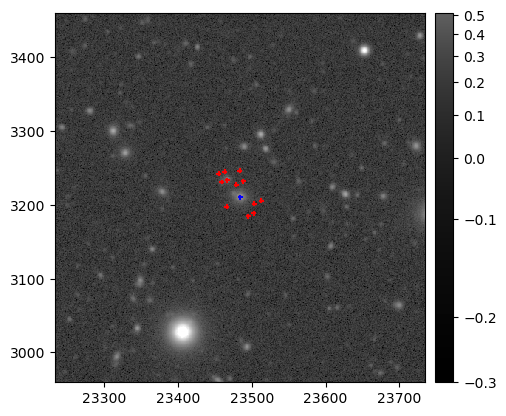

In [6]:
cutout_image = cutout_coadd(butler, ra,dec, band='i', datasetType='deepCoadd',
                            cutoutSideLength=501)

wcs = cutout_image.getWcs()

x0 = float(cutout_image.getX0())
y0 = float(cutout_image.getY0())
width = cutout_image.getWidth()
height = cutout_image.getHeight()

xcorners = [x0, x0+width, x0+width, x0]
ycorners = [y0, y0, y0+width, y0+width]

ra_corners = []
dec_corners = []

for i in range(len(xcorners)):
    radec = wcs.pixelToSky(xcorners[i], ycorners[i])
    ra_corners.append(radec.getRa().asDegrees())
    dec_corners.append(radec.getDec().asDegrees())


fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
with display.Buffering():
    for i in range(len(tab_children[whc])):
        display.dot('+', tab_children[whc][i]['x'], tab_children[whc][i]['y'], ctype=afwDisplay.RED)

display.dot('+', x, y, ctype=afwDisplay.BLUE)
plt.show()




### Questions: 

### 1) Is the footprint that deblender created to split these children still available somewhere? How to access?


### 2) If you were making tutorial about deblender data products, what do you want people to know?



In [7]:
#Notes: dp0.2 has a catalog (deblended flux) that has everyting in merged_det catalog (just parents) each parent has footprint and
#each footprint has peaks that are where children come from. dp0.2  created a new record for each child whihc also
# then has a footprint. footprint = bool array 1=pix is part of footprint 0=pix not part. heavy footprint: each pix 
#now has a flux associated (so its a model of the flux. heavy = data class to store info).

#if you selet all child
# not in object table. need to go back to the catalogs which are butler: deepCoadd_deblendedFlux. Not available from
#TAP or deepCoadd_deblendedModel. we have access to both of these. touch them with butler to see which one is htere.
# catalogs have footprint attached. footprints are only stored for children not parents (to save space). call get_footprint
# in the child catalog. stack for dp0.2 is v23.

# if audience is for users of dp0.2 then look at this and function fred sent. 

# stack club notebook on the deblender. does re-run deblender but at the end it shows how to export those 
# things to images, and this is useful. 

#https://nbviewer.org/github/LSSTScienceCollaborations/StackClub/blob/rendered/Deblending/LsstStackDeblender.nbconvert.ipynb